In [8]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import sys
import os
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.svm import SVC

sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '../')))
from lib.preprocessing_data import Preprocessing
from lib.data_preparation import DataPreparation
from sklearn.model_selection import train_test_split
from lib.word2vec import Word2Vec

In [9]:
def train(preprocessing_method, vectorizer, model, description):
    data_set = DataPreparation().load_data()
    data_set = preprocessing_method(data_set)

    train_df, test_df = train_test_split(
            data_set, test_size=0.2, random_state=1, stratify=data_set['label']
        )

    X_train = train_df['processed_tweet']
    y_train = train_df['label'].to_numpy().astype(int)
    X_test = test_df['processed_tweet']
    y_test = test_df['label'].to_numpy().astype(int)
    
    if description.split()[0] == 'word2vec':
        vectorizer = Word2Vec(X_train, 10)
        X_train_vector = vectorizer.word2vec()
        vectorizer = Word2Vec(X_test, 10)
        X_test_vector = vectorizer.word2vec()
    else:
        X_train_vector = vectorizer.fit_transform(X_train.apply(lambda row: ' '.join(row)))
        X_test_vector = vectorizer.transform(X_test.apply(lambda row: ' '.join(row)))
    
    model.fit(X_train_vector, y_train)
    y_pred = model.predict(X_test_vector)

    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy for {description}: {accuracy}")
    return accuracy


In [10]:

preprocessing_methods = {
    "lemmatization": Preprocessing().lemmatization,
    "tokenization": Preprocessing().tokenization,
    "stemming": Preprocessing().stemming,
}
vectorizers = {
    "TF-IDF": TfidfVectorizer(),
    "Bag of words": CountVectorizer(binary=False),
    "o or 1 if word exists": CountVectorizer(binary=True),
    # "word2vec": None #Accuracy for word2vec + lemmatization + Logistic Regression: 0.396067415730 (epoch=10)
}

models = {
    "Logistic Regression": LogisticRegression(),
    "MultinomialNB": MultinomialNB(),
    "SVC": SVC(),
}

results = []

for preprocessing_name, preprocessing_method in preprocessing_methods.items():
    for vectorizer_name, vectorizer in vectorizers.items():
        for model_name, model in models.items():
            description = f"{vectorizer_name} + {preprocessing_name} + {model_name}"
            accuracy = train(preprocessing_method, vectorizer, model, description)
            results.append((description, accuracy))



Accuracy for TF-IDF + lemmatization + Logistic Regression: 0.8735955056179775
Accuracy for TF-IDF + lemmatization + MultinomialNB: 0.8441011235955056
Accuracy for TF-IDF + lemmatization + SVC: 0.8651685393258427
Accuracy for Bag of words + lemmatization + Logistic Regression: 0.8637640449438202
Accuracy for Bag of words + lemmatization + MultinomialNB: 0.8539325842696629
Accuracy for Bag of words + lemmatization + SVC: 0.8426966292134831
Accuracy for o or 1 if word exists + lemmatization + Logistic Regression: 0.8651685393258427
Accuracy for o or 1 if word exists + lemmatization + MultinomialNB: 0.8539325842696629
Accuracy for o or 1 if word exists + lemmatization + SVC: 0.8426966292134831
Accuracy for TF-IDF + tokenization + Logistic Regression: 0.8623595505617978
Accuracy for TF-IDF + tokenization + MultinomialNB: 0.8342696629213483
Accuracy for TF-IDF + tokenization + SVC: 0.8609550561797753
Accuracy for Bag of words + tokenization + Logistic Regression: 0.8609550561797753
Accuracy 

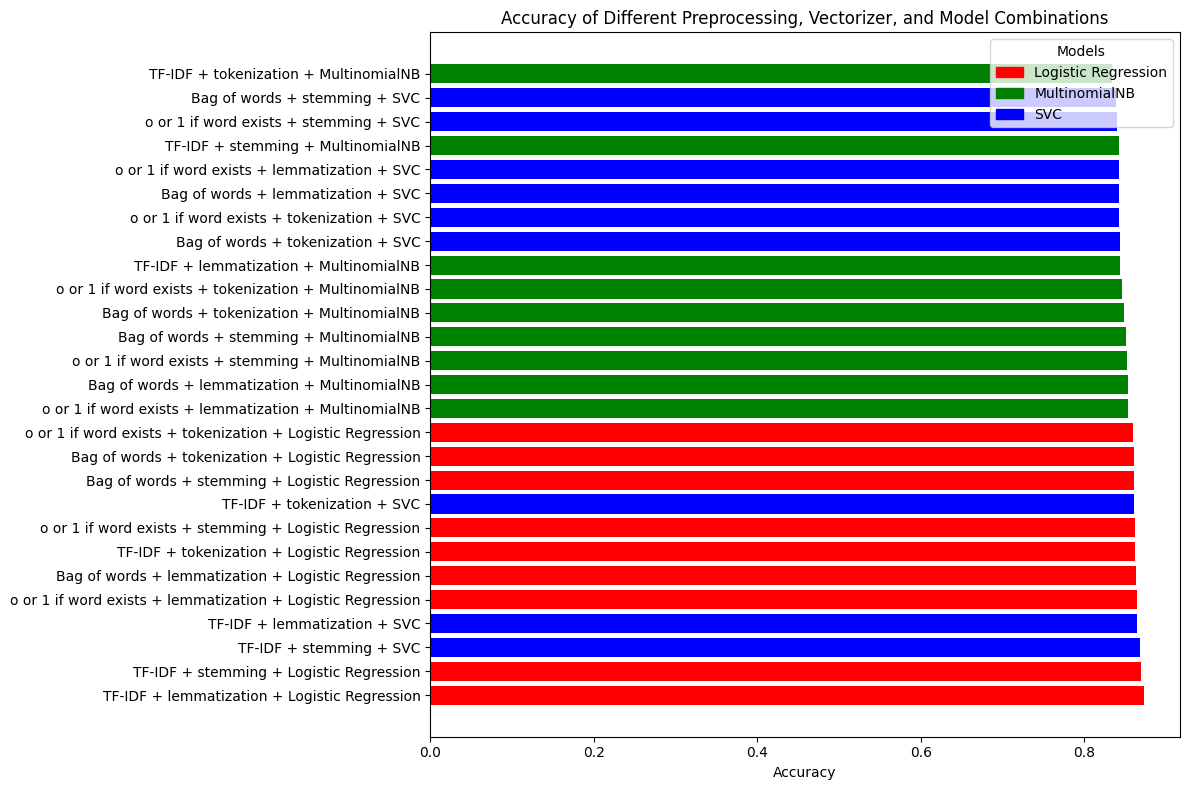

In [11]:
import matplotlib.pyplot as plt
import pandas as pd

results_df = pd.DataFrame(results, columns=["Description", "Accuracy"])
results_df["Model"] = results_df["Description"].apply(lambda x: x.split("+")[-1].strip())

model_colors = {
    "Logistic Regression": "red",
    "MultinomialNB": "green",
    "SVC": "blue",
}

results_df["Color"] = results_df["Model"].map(model_colors)
results_df.sort_values(by="Accuracy", ascending=False, inplace=True)

plt.figure(figsize=(12, 8))
plt.barh(
    results_df["Description"], 
    results_df["Accuracy"], 
    color=results_df["Color"]
)

handles = [plt.Rectangle((0, 0), 1, 1, color=color) for color in model_colors.values()]
labels = list(model_colors.keys())

plt.legend(handles, labels, title="Models")
plt.xlabel("Accuracy")
plt.title("Accuracy of Different Preprocessing, Vectorizer, and Model Combinations")
plt.tight_layout()
plt.show()
